In [90]:
import keras
from keras.preprocessing import image
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.densenet import preprocess_input
from tensorflow.keras.models import load_model

import pandas as pd
import numpy as np
from pathlib import Path

import matplotlib
matplotlib.use("Agg") 
import matplotlib.pyplot as plt

In [92]:
dtrain = pd.read_csv("/kaggle/input/chexpertv10small/CheXpert-v1.0-small/train.csv")
dtrain = dtrain.fillna(0)

dnew = pd.read_csv("/kaggle/input/chexpertv10small/CheXpert-v1.0-small/valid.csv")
dnew = dnew.fillna(0)

dtrain = pd.concat([dtrain, dnew])

dtrain = dtrain[~dtrain[dtrain.columns[3]].str.contains("Lateral")]
dtrain = dtrain.drop(["Sex", "Age", "Frontal/Lateral", "AP/PA"], axis=1)
dtrain = dtrain.replace(-1,1)

In [93]:
dtrain["Path"] = '/kaggle/input/chexpertv10small/' + dtrain["Path"] 
dtrain.head()

,Path,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices
0,/kaggle/input/chexpertv10small/CheXpert-v1.0-s...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,/kaggle/input/chexpertv10small/CheXpert-v1.0-s...,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2,/kaggle/input/chexpertv10small/CheXpert-v1.0-s...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,/kaggle/input/chexpertv10small/CheXpert-v1.0-s...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,/kaggle/input/chexpertv10small/CheXpert-v1.0-s...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
dvalid_size = round(0.1*dtrain.shape[0])
dtest_size = dvalid_size

dte_o = dtrain[dtrain.shape[0]-dvalid_size:dtrain.shape[0]+1]

In [8]:
dte_o.head(10)

,Path,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices
203595,/kaggle/input/chexpertv10small/CheXpert-v1.0-s...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
203596,/kaggle/input/chexpertv10small/CheXpert-v1.0-s...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
203597,/kaggle/input/chexpertv10small/CheXpert-v1.0-s...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
203598,/kaggle/input/chexpertv10small/CheXpert-v1.0-s...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
203599,/kaggle/input/chexpertv10small/CheXpert-v1.0-s...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
203600,/kaggle/input/chexpertv10small/CheXpert-v1.0-s...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
203601,/kaggle/input/chexpertv10small/CheXpert-v1.0-s...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
203602,/kaggle/input/chexpertv10small/CheXpert-v1.0-s...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
203603,/kaggle/input/chexpertv10small/CheXpert-v1.0-s...,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
203604,/kaggle/input/chexpertv10small/CheXpert-v1.0-s...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


/kaggle/input/chexpertv10small/CheXpert-v1.0-small/train/patient04816/study2/view1_frontal.jpg
1/1 [==============================] - 3s 3s/step
/kaggle/input/chexpertv10small/CheXpert-v1.0-small/train/patient04816/study2/view1_frontal.jpg
Predicted Class: [1 0 0 0 0 0 0 0 0 0 0 0 0 1]
True Class:
 No Finding                    0.0
Enlarged Cardiomediastinum    0.0
Cardiomegaly                  0.0
Lung Opacity                  1.0
Lung Lesion                   0.0
Edema                         1.0
Consolidation                 0.0
Pneumonia                     1.0
Atelectasis                   1.0
Pneumothorax                  0.0
Pleural Effusion              1.0
Pleural Other                 0.0
Fracture                      0.0
Support Devices               0.0
Name: 19362, dtype: object


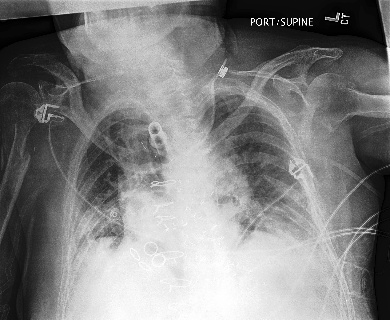

In [110]:
model_F = load_model('/kaggle/input/densenet-model/model_DenseNet121_Full_Sample.h5')
target_size = (224, 224)

def predict_single_image(image_path):
    img = load_img(image_path, target_size=target_size)
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    prediction = model_F.predict(img_array)
    predicted_class = (prediction >= 0.5).astype(int)

    return predicted_class[0]

image_path = dte_o.iloc[100, 0]
print(image_path)
prediction_result = predict_single_image(image_path)
y_true_single = dte_o.iloc[100,1:]  # Exclude the image path colum
print(dte_o.iloc[100,0])

print("Predicted Class:", prediction_result)
print("True Class:\n", y_true_single)

Load_image = tf.keras.preprocessing.image.load_img(image_path)
Load_image

/kaggle/input/chexpertv10small/CheXpert-v1.0-small/train/patient40638/study1/view1_frontal.jpg
1/1 [==============================] - 3s 3s/step
/kaggle/input/chexpertv10small/CheXpert-v1.0-small/train/patient40638/study1/view1_frontal.jpg
Predicted Class: [0 0 0 0 0 0 0 0 1 0 0 0 0 0]
True Class:
 No Finding                    1.0
Enlarged Cardiomediastinum    0.0
Cardiomegaly                  0.0
Lung Opacity                  0.0
Lung Lesion                   0.0
Edema                         0.0
Consolidation                 0.0
Pneumonia                     0.0
Atelectasis                   0.0
Pneumothorax                  0.0
Pleural Effusion              0.0
Pleural Other                 0.0
Fracture                      0.0
Support Devices               0.0
Name: 173995, dtype: object


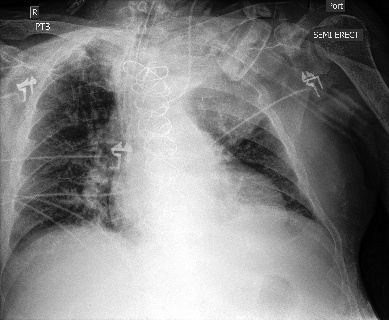

In [111]:
model_F = load_model('/kaggle/input/densenet-model/model_DenseNet121_Full_Sample.h5')
target_size = (224, 224)

def predict_single_image(image_path):
    img = load_img(image_path, target_size=target_size)
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    prediction = model_F.predict(img_array)
    predicted_class = (prediction >= 0.5).astype(int)

    return predicted_class[0]

image_path = dte_o.iloc[101, 0]
print(image_path)
prediction_result = predict_single_image(image_path)
y_true_single = dte_o.iloc[101,1:]  # Exclude the image path colum
print(dte_o.iloc[101,0])

print("Predicted Class:", prediction_result)
print("True Class:\n", y_true_single)

Load_image = tf.keras.preprocessing.image.load_img(image_path)
Load_image

/kaggle/input/chexpertv10small/CheXpert-v1.0-small/train/patient31619/study2/view1_frontal.jpg
1/1 [==============================] - 3s 3s/step
/kaggle/input/chexpertv10small/CheXpert-v1.0-small/train/patient31619/study2/view1_frontal.jpg
Predicted Class: [0 0 0 1 0 1 0 1 0 0 0 0 1 1]
True Class:
 No Finding                    0.0
Enlarged Cardiomediastinum    0.0
Cardiomegaly                  0.0
Lung Opacity                  1.0
Lung Lesion                   0.0
Edema                         1.0
Consolidation                 1.0
Pneumonia                     0.0
Atelectasis                   1.0
Pneumothorax                  0.0
Pleural Effusion              1.0
Pleural Other                 1.0
Fracture                      0.0
Support Devices               1.0
Name: 131957, dtype: object


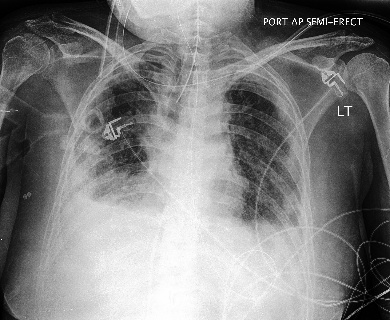

In [112]:
model_F = load_model('/kaggle/input/densenet-model/model_DenseNet121_Full_Sample.h5')
target_size = (224, 224)

def predict_single_image(image_path):
    img = load_img(image_path, target_size=target_size)
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    prediction = model_F.predict(img_array)
    predicted_class = (prediction >= 0.5).astype(int)

    return predicted_class[0]

image_path = dte_o.iloc[102, 0]
print(image_path)
prediction_result = predict_single_image(image_path)
y_true_single = dte_o.iloc[102,1:]  # Exclude the image path colum
print(dte_o.iloc[102,0])

print("Predicted Class:", prediction_result)
print("True Class:\n", y_true_single)

Load_image = tf.keras.preprocessing.image.load_img(image_path)
Load_image

/kaggle/input/chexpertv10small/CheXpert-v1.0-small/train/patient00495/study3/view1_frontal.jpg
1/1 [==============================] - 3s 3s/step
/kaggle/input/chexpertv10small/CheXpert-v1.0-small/train/patient00495/study3/view1_frontal.jpg
Predicted Class: [0 0 0 0 0 0 0 0 1 0 0 0 1 1]
True Class:
 No Finding                    0.0
Enlarged Cardiomediastinum    1.0
Cardiomegaly                  0.0
Lung Opacity                  0.0
Lung Lesion                   0.0
Edema                         0.0
Consolidation                 0.0
Pneumonia                     0.0
Atelectasis                   1.0
Pneumothorax                  0.0
Pleural Effusion              1.0
Pleural Other                 0.0
Fracture                      1.0
Support Devices               0.0
Name: 2068, dtype: object


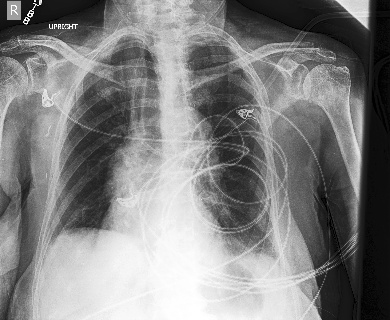

In [113]:
model_F = load_model('/kaggle/input/densenet-model/model_DenseNet121_Full_Sample.h5')
target_size = (224, 224)

def predict_single_image(image_path):
    img = load_img(image_path, target_size=target_size)
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    prediction = model_F.predict(img_array)
    predicted_class = (prediction >= 0.5).astype(int)

    return predicted_class[0]

image_path = dte_o.iloc[103, 0]
print(image_path)
prediction_result = predict_single_image(image_path)
y_true_single = dte_o.iloc[103,1:]  # Exclude the image path colum
print(dte_o.iloc[103,0])

print("Predicted Class:", prediction_result)
print("True Class:\n", y_true_single)

Load_image = tf.keras.preprocessing.image.load_img(image_path)
Load_image

/kaggle/input/chexpertv10small/CheXpert-v1.0-small/train/patient35375/study8/view1_frontal.jpg
1/1 [==============================] - 3s 3s/step
/kaggle/input/chexpertv10small/CheXpert-v1.0-small/train/patient35375/study8/view1_frontal.jpg
Predicted Class: [0 0 0 1 1 0 0 1 0 0 0 0 0 1]
True Class:
 No Finding                    0.0
Enlarged Cardiomediastinum    0.0
Cardiomegaly                  0.0
Lung Opacity                  1.0
Lung Lesion                   0.0
Edema                         1.0
Consolidation                 0.0
Pneumonia                     0.0
Atelectasis                   0.0
Pneumothorax                  0.0
Pleural Effusion              0.0
Pleural Other                 0.0
Fracture                      0.0
Support Devices               1.0
Name: 148952, dtype: object


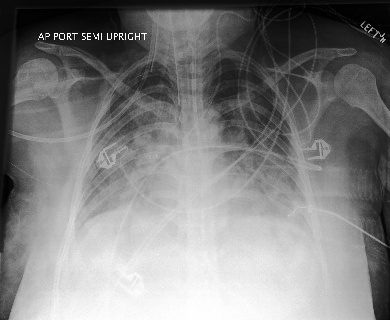

In [114]:
model_F = load_model('/kaggle/input/densenet-model/model_DenseNet121_Full_Sample.h5')
target_size = (224, 224)

def predict_single_image(image_path):
    img = load_img(image_path, target_size=target_size)
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    prediction = model_F.predict(img_array)
    predicted_class = (prediction >= 0.5).astype(int)

    return predicted_class[0]

image_path = dte_o.iloc[104, 0]
print(image_path)
prediction_result = predict_single_image(image_path)
y_true_single = dte_o.iloc[104,1:]  # Exclude the image path colum
print(dte_o.iloc[104,0])

print("Predicted Class:", prediction_result)
print("True Class:\n", y_true_single)

Load_image = tf.keras.preprocessing.image.load_img(image_path)
Load_image

/kaggle/input/chexpertv10small/CheXpert-v1.0-small/train/patient43465/study2/view1_frontal.jpg
1/1 [==============================] - 3s 3s/step
/kaggle/input/chexpertv10small/CheXpert-v1.0-small/train/patient43465/study2/view1_frontal.jpg
Predicted Class: [1 0 0 0 0 0 0 0 0 0 0 0 0 0]
True Class:
 No Finding                    1.0
Enlarged Cardiomediastinum    0.0
Cardiomegaly                  0.0
Lung Opacity                  0.0
Lung Lesion                   0.0
Edema                         0.0
Consolidation                 0.0
Pneumonia                     0.0
Atelectasis                   0.0
Pneumothorax                  0.0
Pleural Effusion              0.0
Pleural Other                 0.0
Fracture                      0.0
Support Devices               0.0
Name: 183823, dtype: object


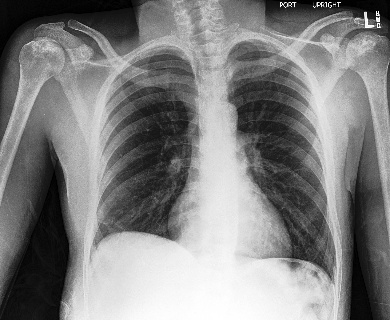

In [115]:
model_F = load_model('/kaggle/input/densenet-model/model_DenseNet121_Full_Sample.h5')
target_size = (224, 224)

def predict_single_image(image_path):
    img = load_img(image_path, target_size=target_size)
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    prediction = model_F.predict(img_array)
    predicted_class = (prediction >= 0.5).astype(int)

    return predicted_class[0]

image_path = dte_o.iloc[105, 0]
print(image_path)
prediction_result = predict_single_image(image_path)
y_true_single = dte_o.iloc[105,1:]  # Exclude the image path colum
print(dte_o.iloc[105,0])

print("Predicted Class:", prediction_result)
print("True Class:\n", y_true_single)

Load_image = tf.keras.preprocessing.image.load_img(image_path)
Load_image